In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
testtree = Tree("/uscms_data/d3/ekoenig/8BAnalysis/analysis/CMSSW_10_2_18/src/sixB/analysis/sixBanalysis/NMSSM_XYY_YToHH_8b_MX_1200_MY_500_accstudies.root")

# testtree = Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1200_MY_500)

In [3]:
testtree.extend(**build_collection(testtree,'H\dY\d','higgs',ptordered=True))

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='DiJet Mass', ylabel='Events'>,
        <AxesSubplot:xlabel='higgs_score', ylabel='Events'>], dtype=object))

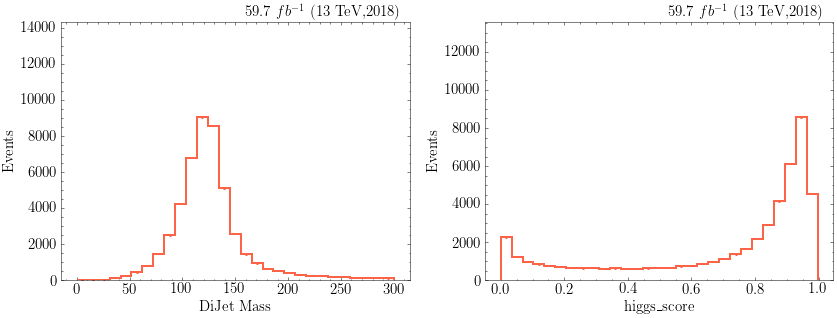

In [4]:
study.quick(
    [testtree],
    varlist=['higgs_m','higgs_score']
)

In [5]:
build_all_dijets(testtree)

In [6]:
import utils.torchUtils as gnn

In [7]:
template = gnn.Dataset("/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/data/template",
                       make_template=True,)

In [8]:
model = gnn.GoldenGCN.load_from_checkpoint(
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/models/golden_classifier/lightning_logs/version_2/checkpoints/epoch=24-step=9024.ckpt",
    dataset=template)

In [9]:
def get_tree_graph(tree, ver='testing', path='/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/data/'):
    sample = tree.sample
    print(sample)
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=100, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [10]:
get_tree_graph(testtree)

MX_1200_MY_500


In [13]:
import torch 
def predict_tree(tree):
    node_scores, edge_itoj_scores, edge_jtoi_scores = [],[],[]
    for graph in tree.graphs:
        node_score, edge_score = model.predict(graph.to(gnn.config.device))
        node_scores.append(node_score)
        
        node_i, node_j = graph.edge_index
        i_to_j = node_i < node_j
        j_to_i = node_j < node_i
        edge_itoj_scores.append(edge_score[i_to_j])
        edge_jtoi_scores.append(edge_score[j_to_i])
        
    node_scores = torch.cat(node_scores).cpu().numpy()
    edge_itoj_scores = torch.cat(edge_itoj_scores).cpu().numpy()
    edge_jtoi_scores = torch.cat(edge_jtoi_scores).cpu().numpy()
    
    node_scores = ak.unflatten(node_scores,ak.num(tree.jet_pt))
    edge_itoj_scores = ak.unflatten(edge_itoj_scores,ak.num(tree.dijet_pt))
    edge_jtoi_scores = ak.unflatten(edge_jtoi_scores,ak.num(tree.dijet_pt))
    
    tree.extend(
        jet_score = node_scores,
        dijet_itoj_score = edge_itoj_scores,
        dijet_jtoi_score = edge_jtoi_scores,
    )

In [15]:
predict_tree(testtree)

In [16]:
build_collection(testtree,'H\dY\d_b\d','bjet',ptordered=True)

{'bjet_m': <Array [[26.4, 20, 14.7, ... 9.28, 11.9, 6.25]] type='68041 * var * float32'>,
 'bjet_genHflag': <Array [[0, 2, 0, 1, 3, ... 2, 3, 1, 3, -1]] type='68041 * var * int32'>,
 'bjet_btag': <Array [[1, 0.999, 0.993, ... 0.00462, 0.0085]] type='68041 * var * float32'>,
 'bjet_ptRegressed': <Array [[327, 294, 114, ... 68.8, 59.3, 31.4]] type='68041 * var * float32'>,
 'bjet_score': <Array [[0.994, 0.996, ... 0.107, 0.0698]] type='68041 * var * float32'>,
 'bjet_pt': <Array [[318, 286, 104, ... 55.4, 55.2, 29.1]] type='68041 * var * float32'>,
 'bjet_mRegressed': <Array [[26.5, 20.9, 16.3, ... 12.1, 6.33]] type='68041 * var * float32'>,
 'bjet_phi': <Array [[0.857, -2.64, ... 2.46, -0.0664]] type='68041 * var * float32'>,
 'bjet_eta': <Array [[0.0711, -0.892, ... 0.496, -0.892]] type='68041 * var * float32'>}

In [17]:
bjets = get_collection(testtree,'bjet',False)
jets = get_collection(testtree,'jet',False)

In [18]:
selected_jets = jets[ak.any(jets.pt[:,:,None] == bjets.pt[:,None],axis=-1)]

(<Figure size 1152x360 with 3 Axes>, <AxesSubplot:ylabel='Events'>)

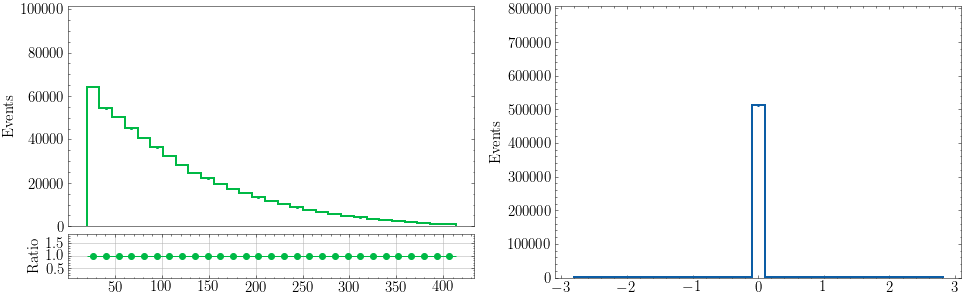

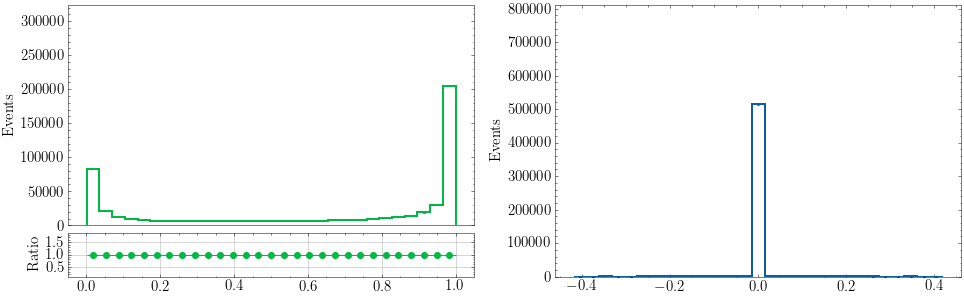

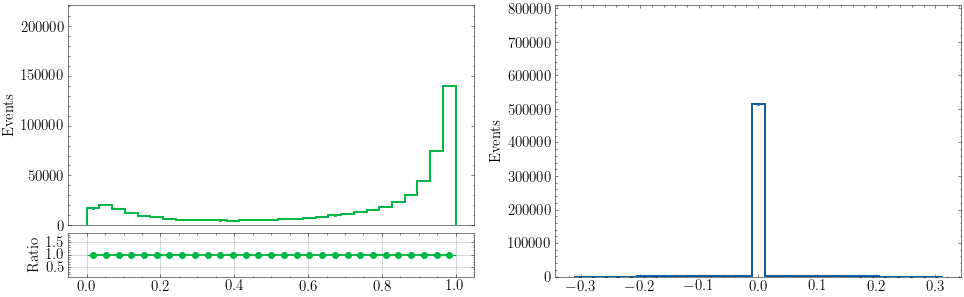

In [19]:

fig,axs = plt.subplots(ncols=2, figsize=(16,5))
hist_multi([selected_jets.pt,bjets.pt], ratio=True, figax=(fig,axs[0]))
hist_multi([selected_jets.pt-bjets.pt], figax=(fig,axs[1]))

fig,axs = plt.subplots(ncols=2, figsize=(16,5))
hist_multi([selected_jets.btag,bjets.btag], ratio=True, figax=(fig,axs[0]))
hist_multi([selected_jets.btag-bjets.btag], figax=(fig,axs[1]))

fig,axs = plt.subplots(ncols=2, figsize=(16,5))
hist_multi([selected_jets.score,bjets.score], ratio=True, figax=(fig,axs[0]))
hist_multi([selected_jets.score-bjets.score], figax=(fig,axs[1]))

In [24]:
higgs = get_collection(testtree,'higgs',False)
dijets = get_collection(testtree,'dijet',False)

In [30]:
dijets.signalId

<Array [[-1, 0, -1, -1, ... -1, -1, -1, -1]] type='68041 * var * ?int64'>

In [76]:
h1b1_mask = jets.pt == higgs.b1_pt[:,0] 
h1b2_mask = jets.pt == higgs.b2_pt[:,0]

In [77]:
jet_ids = ak.local_index(jets.pt,axis=-1)

In [84]:
h1b_ids = ak.concatenate([jet_ids[h1b1_mask],jet_ids[h1b2_mask]],axis=-1)

In [92]:
h1_mask = (dijets.j1Idx == h1b_ids[:,0]) & (dijets.j2Idx == h1b_ids[:,1])

(<Figure size 384x360 with 2 Axes>, <AxesSubplot:ylabel='Events'>)

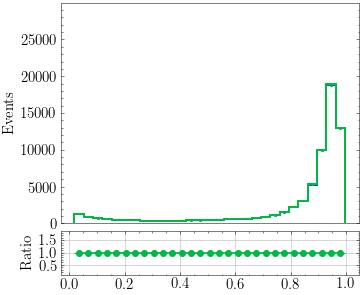

In [105]:
hist_multi([dijets[h1_mask].itoj_score,higgs.score[:,0]],ratio=True)

In [28]:
selected_higgs = dijets[ak.any(dijets.pt[:,:,None] == higgs.pt[:,None],axis=-1)]

In [29]:
selected_higgs

<Array [{m: [], dm: [], ... jtoi_score: []}] type='68041 * {"m": var * float32, ...'>

In [20]:
select_higgs(testtree, field='itoj_score', nhiggs=4)

In [21]:
testtree.higgs_m

<Array [[191, 146, 138, ... 134, 139, 123]] type='68041 * var * float32'>

In [22]:
testtree.gnn_higgs_m

<Array [[132, 124, 187, ... 126, 116, 114]] type='68041 * var * float32'>

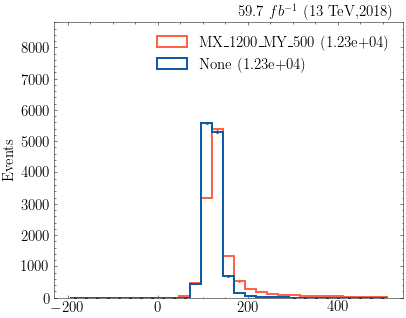

(<Figure size 432x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

In [23]:
study.overlay(
    [testtree],
    varlist=['higgs_m:0','gnn_higgs_m:0'],
    legend=True,
)

In [106]:
def count_higgs(t):    
    nfound_h = ak.sum((t.higgs_b1_genHflag != -1) & (t.higgs_b2_genHflag != -1) & (t.higgs_b1_genHflag == t.higgs_b2_genHflag),axis=-1)
    nfound_gnn_h = ak.sum(t.gnn_higgs_signalId>-1,axis=-1)
    t.extend(
        nfound_h=nfound_h,
        nfound_gnn_h=nfound_gnn_h
    )
    
count_higgs(testtree)

0.389137980908302
0.389137980908302


(<Figure size 384x360 with 2 Axes>,
 <AxesSubplot:ylabel='Fraction of Events Above (CDF)'>)

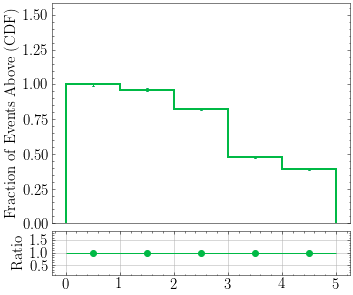

In [107]:
tree = testtree

mask = tree.nfound_presel == 8
nfound_mass = tree.nfound_h[mask]

print(np.sum(nfound_mass==4)/np.sum(mask))

nfound_gnn = tree.nfound_gnn_h[mask]

print(np.sum(nfound_gnn==4)/np.sum(mask))

hist_multi([nfound_mass,nfound_gnn],ratio=True,cumulative=-1)